# GCNAE: capturing feature-network dependencies

## Imports and setup

In [1]:
import time
import random
import os

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
MODEL_NAME = 'vae-explore'

In [3]:
random.seed(1)
np.random.seed(1)

### Model drawing routines

In [4]:
def plot_ξ_distribution(glk, q_model, adj, features):
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                        adj.shape[0], 1,
                                        p=1, q=1, neighbour_samples=None))
    q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)

    # KDE plots
    q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax1)
    ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ.T):
        ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Test graphs

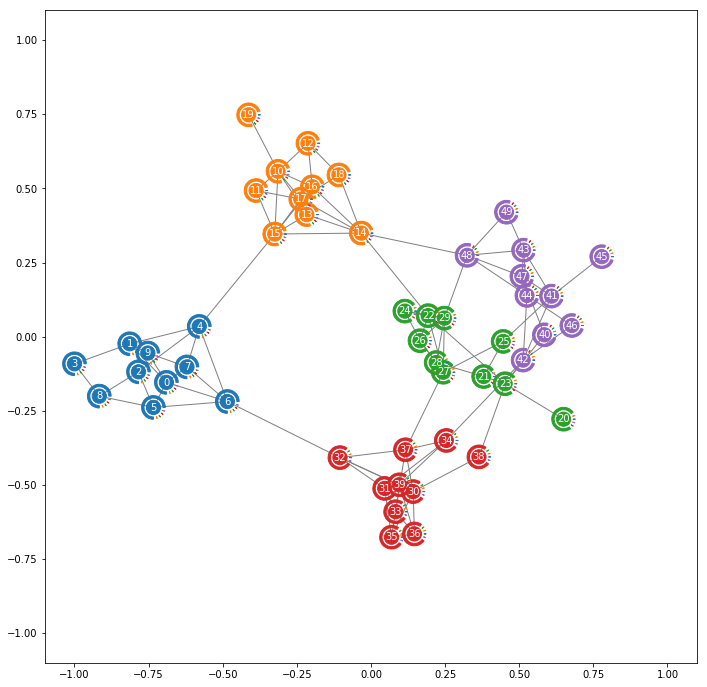

In [5]:
# Parameters
l = 5
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
viz.draw_network(g, labels=labels);

- ✔ comms 1 & 2 have 1 0 0 0 0, comms 3, 4, 5 have 0 1 0 0 0
- ✔ same, but with an `eye` added to the features
- ✔ same, but shear in the middle of comm 3
- ✔ one-hot that is shifted from network structure
- ✔ one-hot that is finer than network structure
- several ones (random # and random position) for all nodes:
  - ✔ random
  - ✔ correlated with comms
  - ✔ finer than comms
  - ✔ grosser than comms

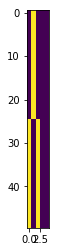

In [59]:
labels = np.zeros((l * k, l), dtype=np.float32)
ids1 = np.random.choice(range(l), 2)
ids2 = np.random.choice(range(l), 2)
labels[list(zip(*itertools.product(range(int(k * 2.5)), ids1)))] = 1
labels[list(zip(*itertools.product(range(int(k * 2.5), l * k), ids2)))] = 1
plt.imshow(labels)

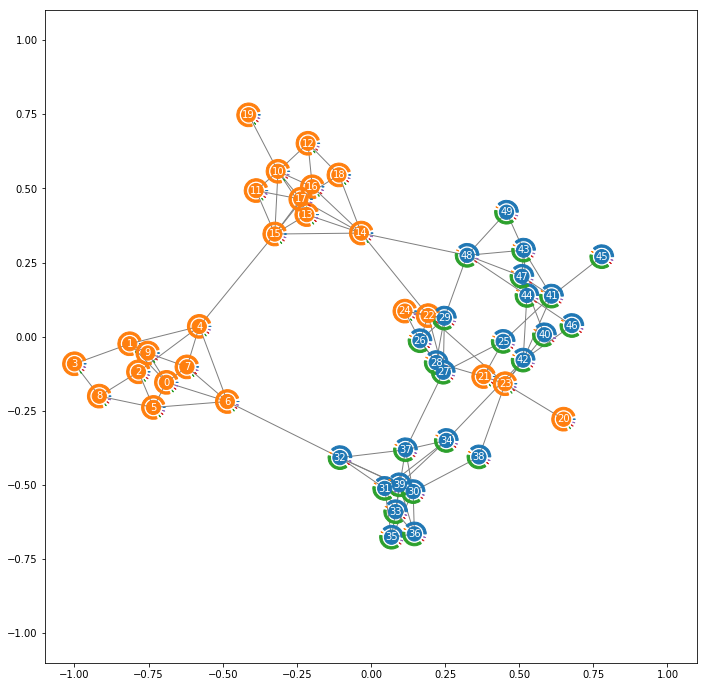

In [60]:
viz.draw_network(g, labels=labels);

## Build the VAE

In [61]:
# VAE Parameters
n_nodes = l * k
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = labels.shape[1], 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False


# Actual VAE
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)

#def build_p_builder(dims, use_bias=False):
#    dim_data, dim_l1, dim_ξ = dims
#
#    def p_builder(p_input):
#        # CANDO: change activation
#        p_adj = layers.Bilinear(0, use_bias=use_bias,
#                                kernel_regularizer='l2', bias_regularizer='l2',
#                                name='p_adj')([p_input, p_input])
#        return ([p_adj], ('SigmoidBernoulliAdjacency',))
#
#    return p_builder

p_builder = ae.build_p_builder(dims, use_bias=use_bias)

vae, vae_codecs = ae.build_vae(
    (q_model, q_codecs),
    p_builder,
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0,  # p adj loss
        1.0,  # p v loss
    ],
)

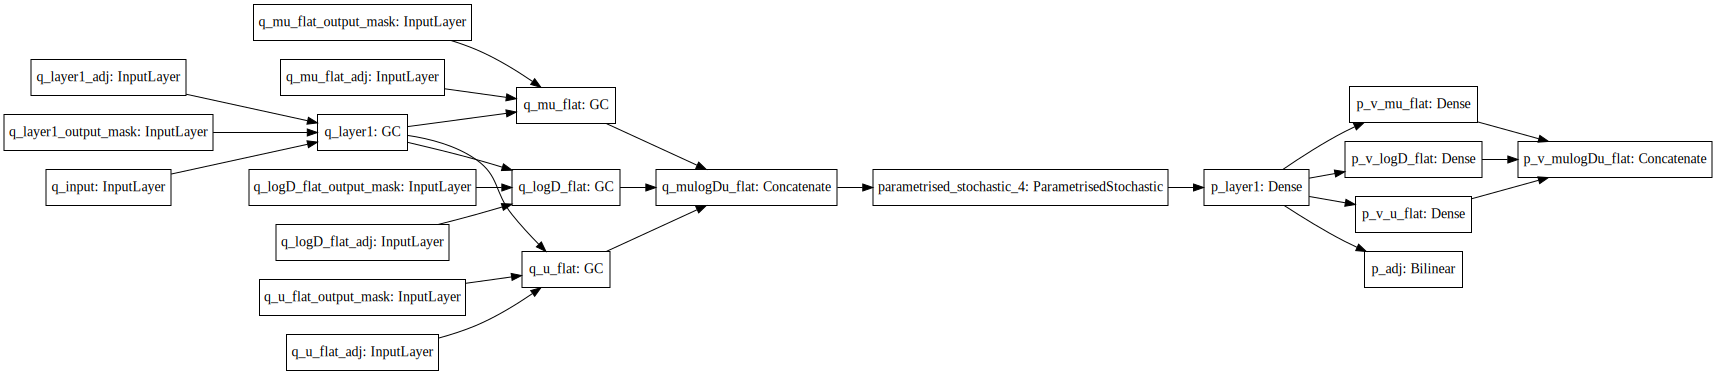

In [62]:
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

## Target function

In [63]:
features = utils.scale_center(labels)

def target_func(batch_adj, required_nodes, final_nodes):
    return [
        np.zeros(1), # ignored
        utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]), 0, n_ξ_samples), 0, 1),
        utils.expand_dims_tile(features[final_nodes], 1, n_ξ_samples),
    ]

## Before training

$\xi$ averages and distributions for each community, real and predicted adjacency matrices

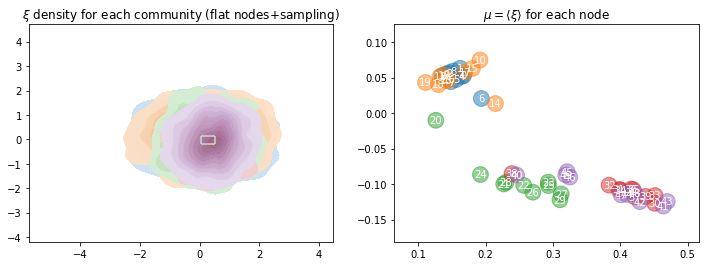

In [64]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

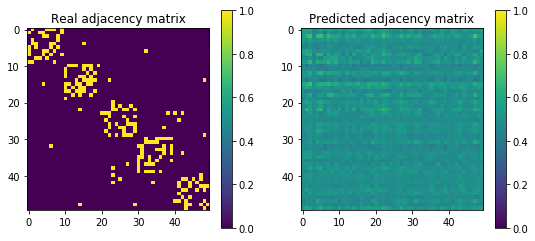

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0]).mean(axis=0))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

**Train**

In [66]:
rm -r ./logs

rm: cannot remove './logs': No such file or directory


In [67]:
n_epochs = 5000
seeds_per_batch = n_nodes
max_walk_length = 1
p = 1
q = 1
neighbour_samples = None

steps_per_epoch = int(np.ceil(len(features) / seeds_per_batch))

In [68]:
history = vae.fit_generator_feed(batching.batches(vae, adj, labels, target_func,
                                                  seeds_per_batch, max_walk_length,
                                                  p=p, q=q, neighbour_samples=neighbour_samples),
                                 steps_per_epoch=steps_per_epoch,
                                 epochs=n_epochs,
                                 check_array_lengths=False,
                                 shuffle=False,
                                 verbose=0,
                                 callbacks=[
                                     #keras.callbacks.TensorBoard(),
                                     #ae.ModelBatchCheckpoint(MODEL_NAME + '.batch-checkpoint.h5',
                                     #                        monitor='loss', period=10,
                                     #                        save_best_only=True),
                                     #keras.callbacks.ModelCheckpoint(MODEL_NAME + '.epoch-checkpoint.h5',
                                     #                                monitor='loss', period=10,
                                     #                                save_best_only=True),
                                     #TQDMCallback(),
                                 ])

/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Usually, the cell above complains with "UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.". See these for more details:
* https://stackoverflow.com/questions/35892412/tensorflow-dense-gradient-explanation#35896823
* https://stackoverflow.com/questions/39111373/tensorflow-chaining-tf-gather-produces-indexedslices-warning

---

## Communities 1, 2 and half of community 3 have 1 or 2 random ones, the rest of community 3, and communities 4, 5 have another 1 or 2 random ones

Loss weights 1, 1, 1

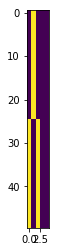

In [69]:
plt.imshow(labels)

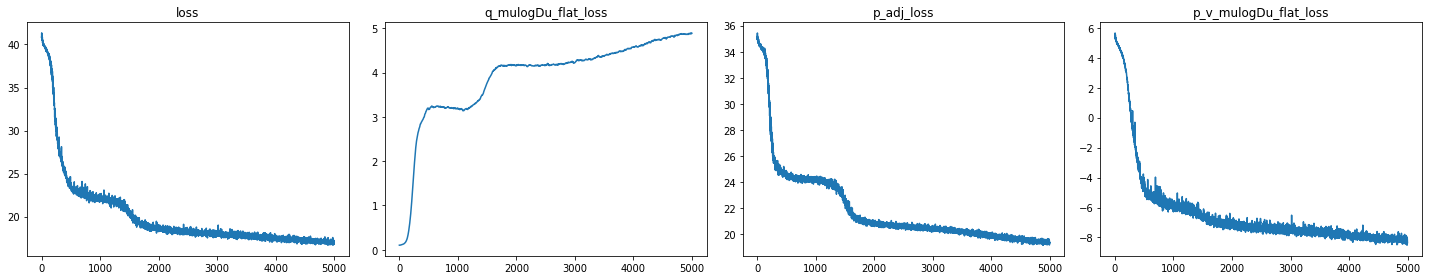

In [70]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

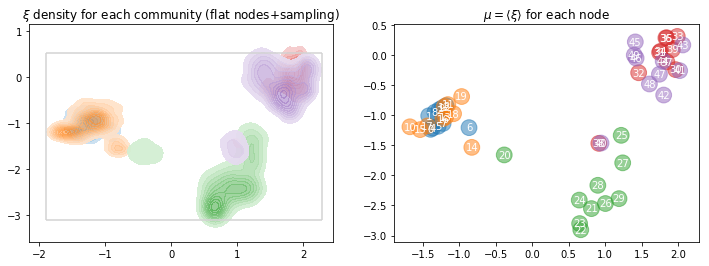

In [71]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

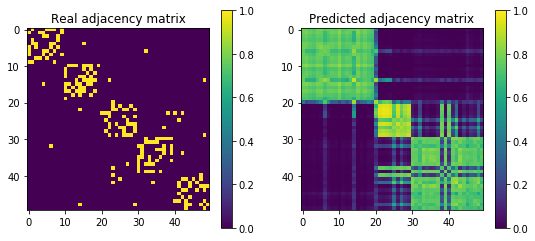

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## Communities 1 and 2 have 1 or 2 random ones, communities 3, 4, 5 have another 2 random ones

Loss weights 1, 1, 1

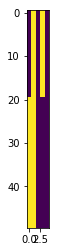

In [55]:
plt.imshow(labels)

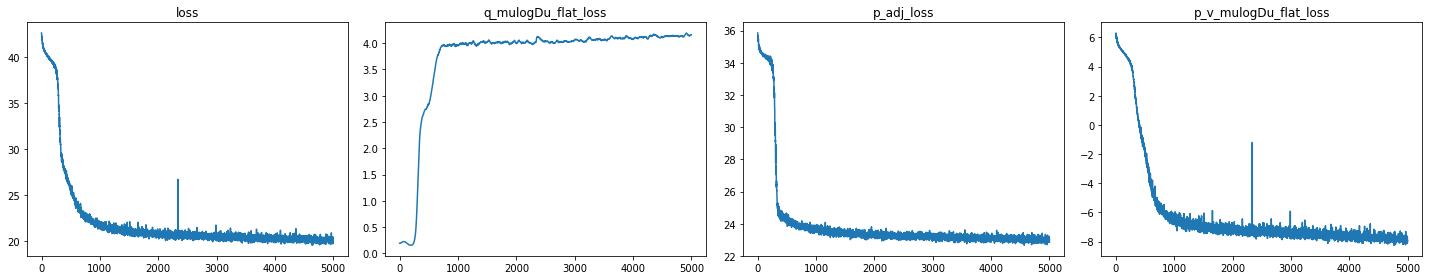

In [56]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

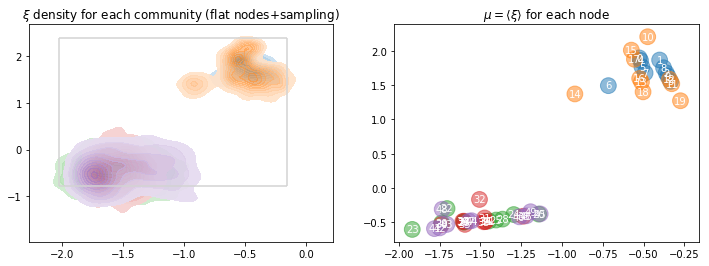

In [57]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

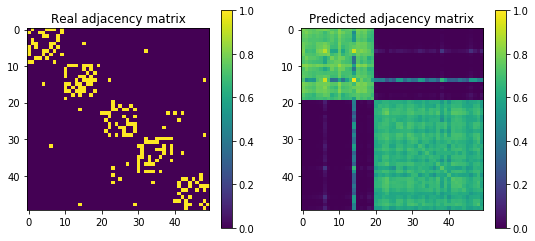

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## 1 or 2 random ones for each half-community

Loss weights 1, 1, 1

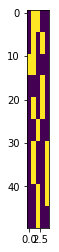

In [39]:
plt.imshow(labels)

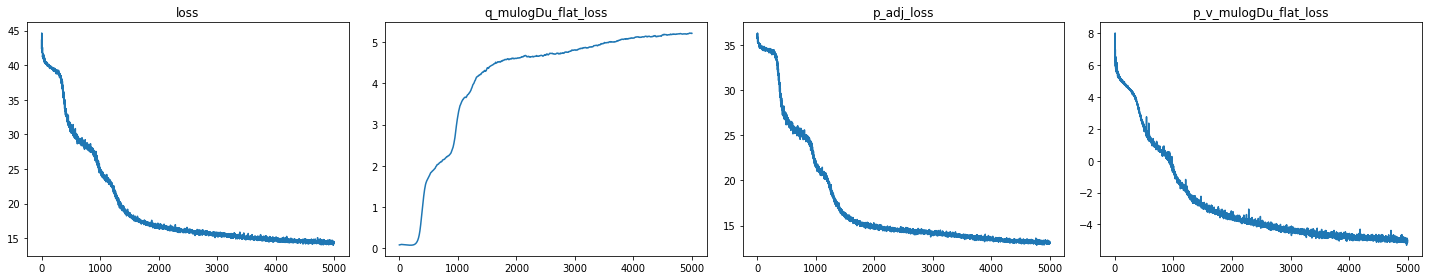

In [40]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

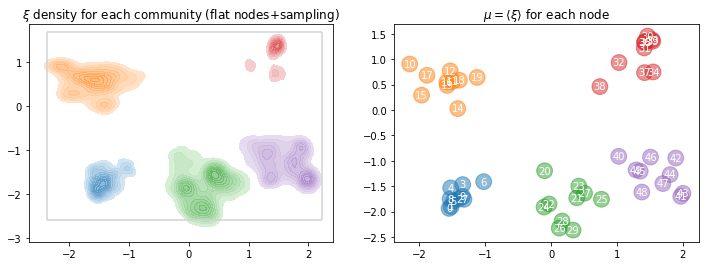

In [41]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

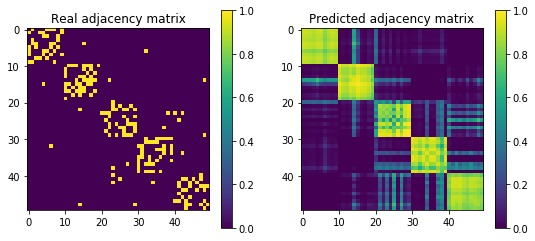

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## 1 or 2 random ones for each community

Loss weights 1, 1, 1

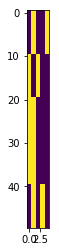

In [23]:
plt.imshow(labels)

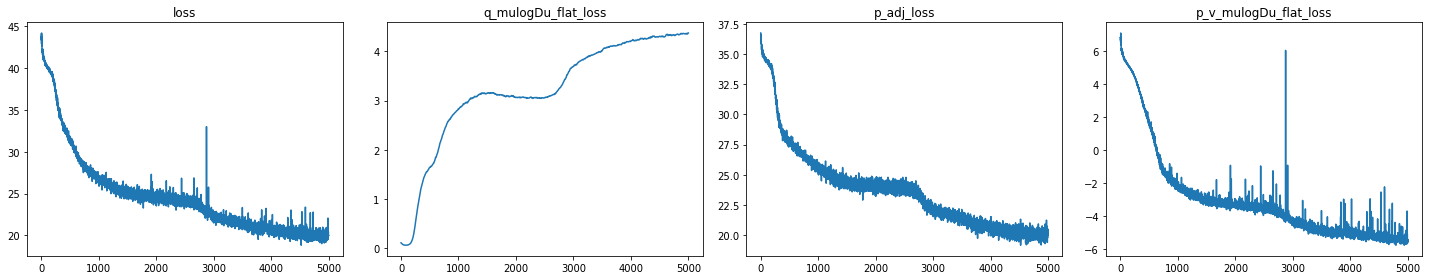

In [24]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

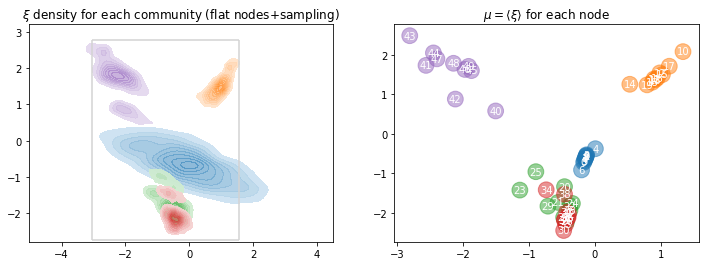

In [25]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

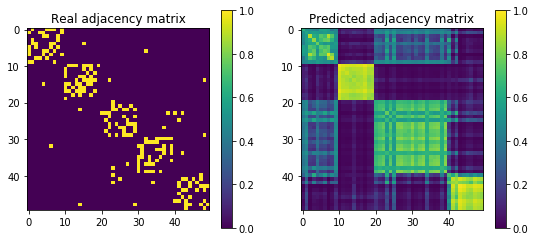

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## One-hot encoding finer than the network structure

Loss weights 1, 1, 1

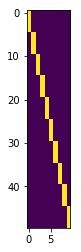

In [18]:
plt.imshow(labels)

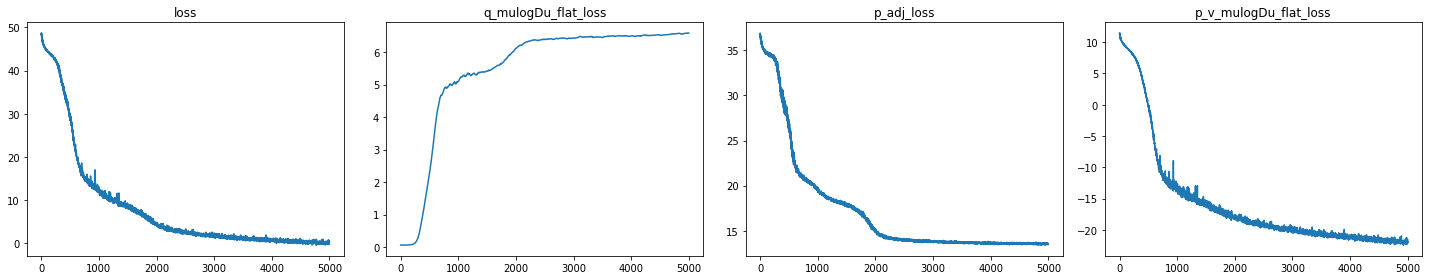

In [19]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

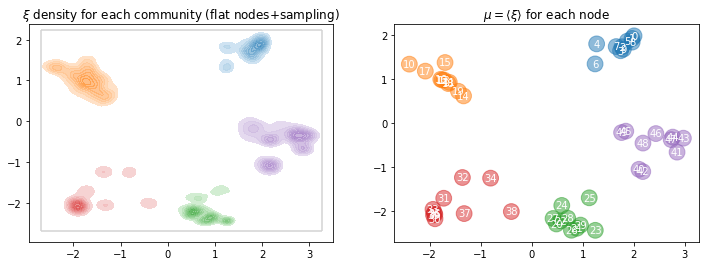

In [20]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

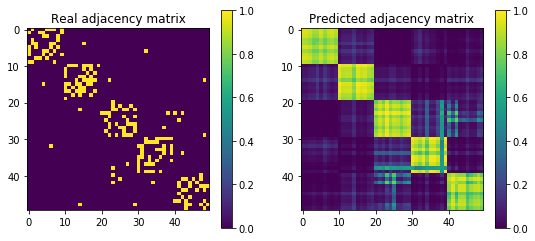

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## One-hot encoding shifted from the network structure

Loss weights 1, 1, 1

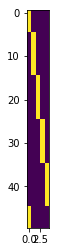

In [161]:
plt.imshow(labels)

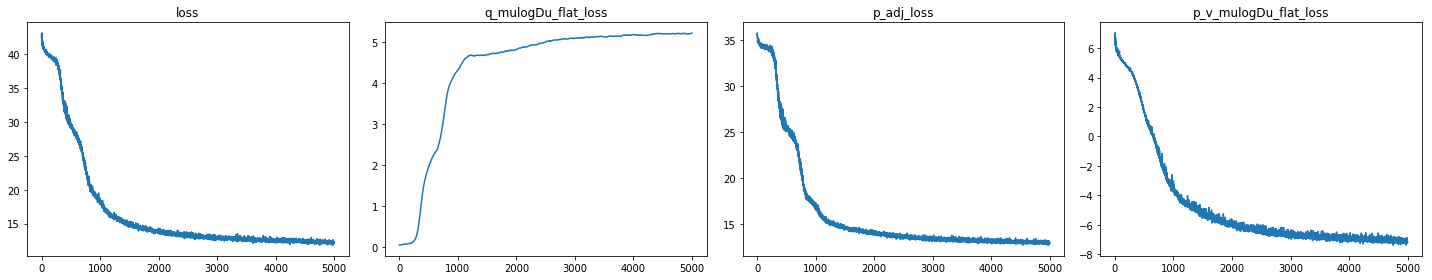

In [162]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

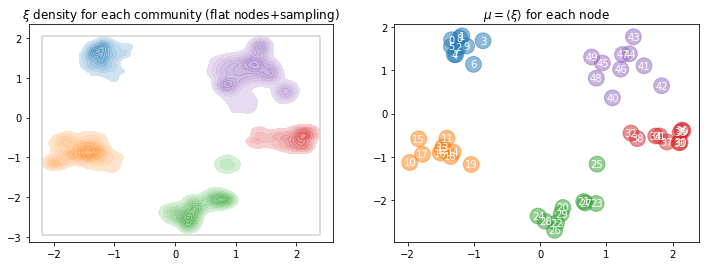

In [163]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

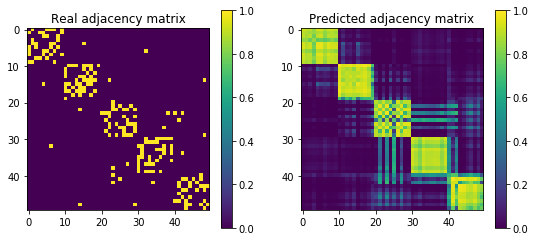

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## All nodes have 1 or 2 random features at 1, the rest at 0

Loss weights 1, 1, 1

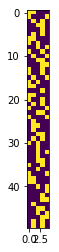

In [143]:
plt.imshow(labels)

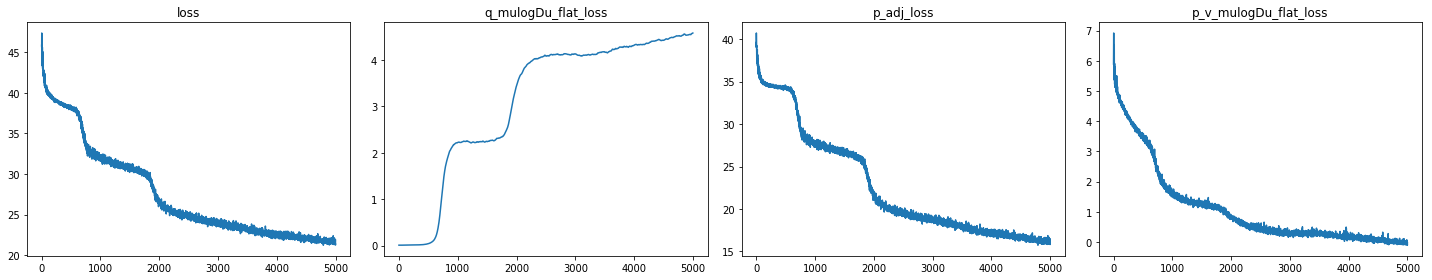

In [144]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

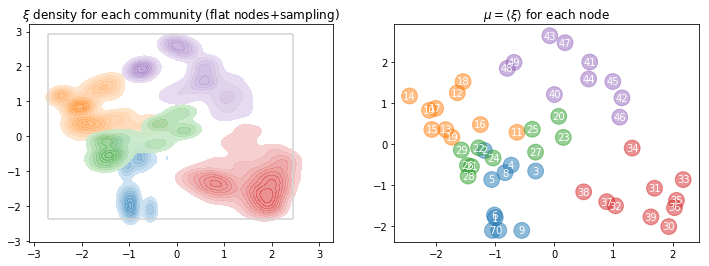

In [145]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

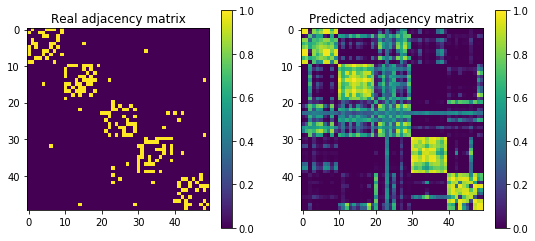

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## Communities 1, 2, and half of 3 have `[1, 0, 0, 0, 0]`, other half of 3, and 4, 5 have `[0, 1, 0, 0, 0]`

Loss weights 1, 1, 1

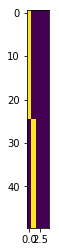

In [127]:
plt.imshow(labels)

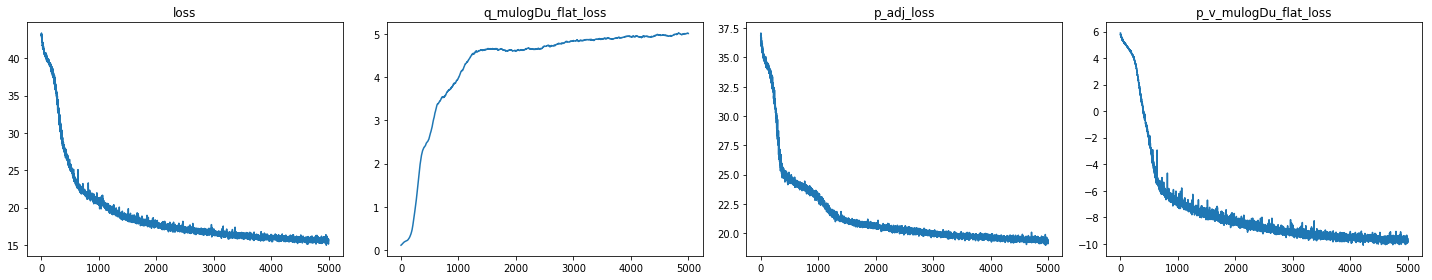

In [128]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

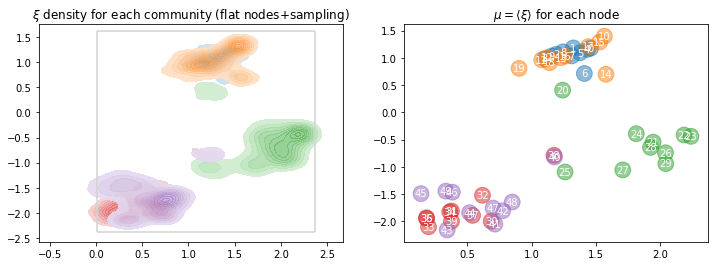

In [129]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

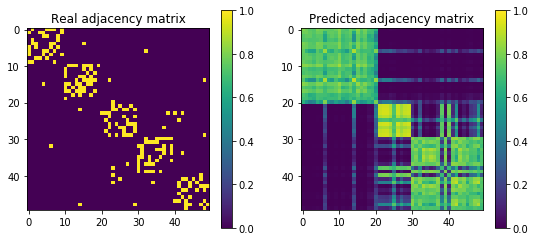

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## Communities 1 & 2 have `[1, 0, 0, 0, 0]` + `eye`, comms 3, 4, 5 have `[0, 1, 0, 0, 0]` + `eye`

Loss weights 1, 1, 1

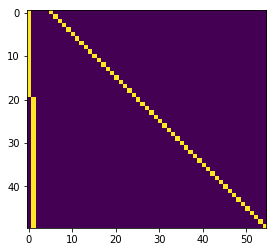

In [80]:
plt.imshow(labels)

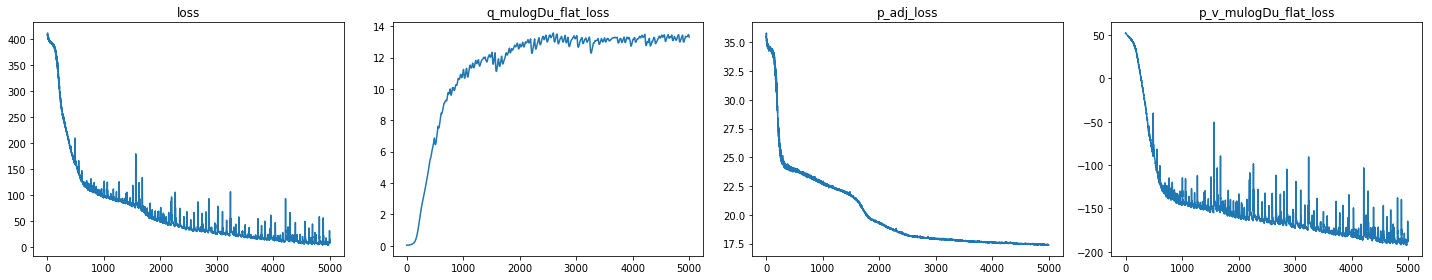

In [81]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

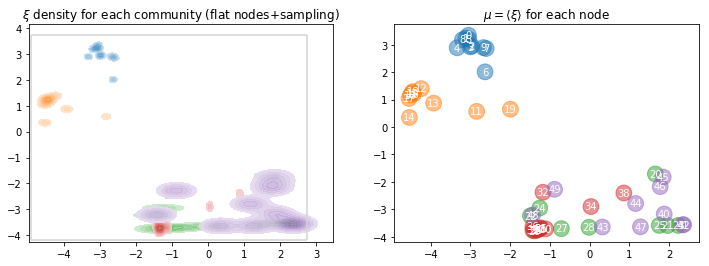

In [82]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

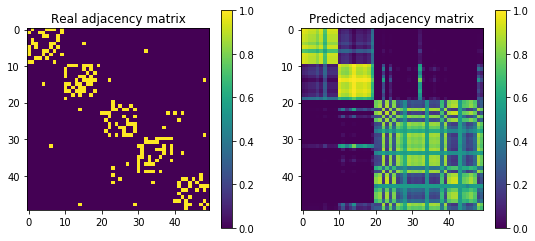

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## Communities 1 & 2 have `[1, 0, 0, 0, 0]`, comms 3, 4, 5 have `[0, 1, 0, 0, 0]`

Loss weights 1, 10, 1

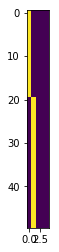

In [31]:
plt.imshow(labels)

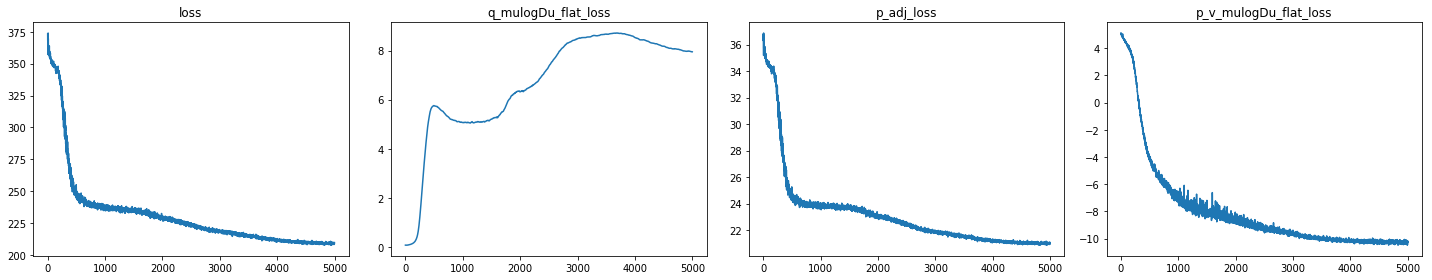

In [48]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

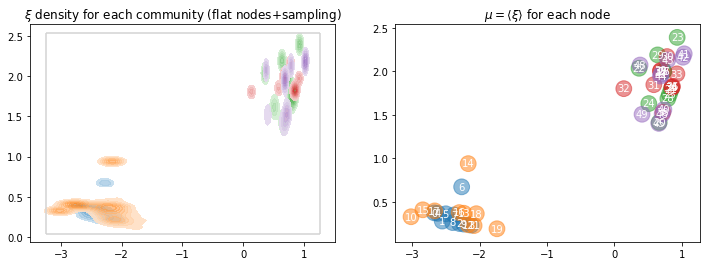

In [49]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

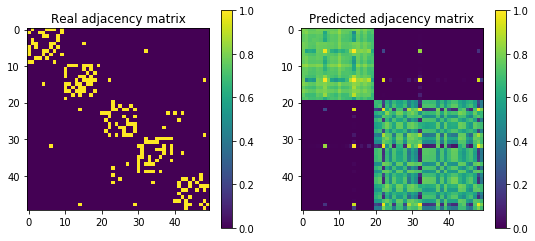

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

---

## Communities 1 & 2 have `[1, 0, 0, 0, 0]`, comms 3, 4, 5 have `[0, 1, 0, 0, 0]`

Loss weights 1, 1, 1

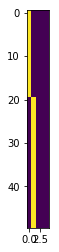

In [31]:
labels = np.zeros((l * k, l), dtype=np.float32)
labels[:2 * k, 0] = 1
labels[2 * k:, 1] = 1
plt.imshow(labels)

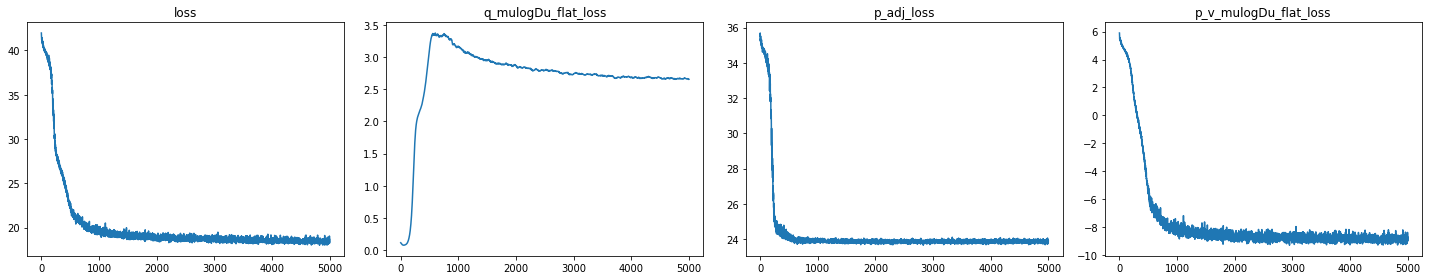

In [41]:
fig, axes = plt.subplots(1, len(history.history), figsize=(len(history.history) * 5, 4))
for i, (title, values) in enumerate(history.history.items()):
    axes[i].plot(values)
    axes[i].set_title(title)
fig.tight_layout()

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

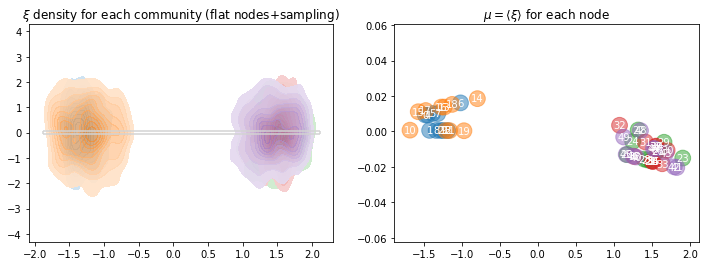

In [42]:
plot_ξ_distribution((g, l, k), q_model, adj, features)

Predicted adjacency matrix:

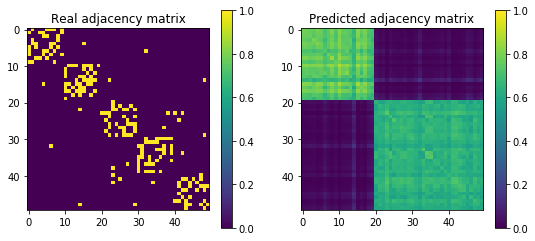

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
adj_pred = vae.predict_on_fed_batch(x, feeds=feeds)[1]
im2 = ax2.imshow(scipy.special.expit(adj_pred[0].mean(axis=0)))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);